# Point Source Tutorial

This is a quick demonstration of how to model both extended objects and point sources in the same scence. After more testing we hope to replace this with a more robust demonstration of crowded field photometry, using an iterative detection/deblending procedure. In the meantime feel free to create your own algorithm for crowded fields and let us know how it goes on the [DESC Blending](https://lsstc.slack.com/messages/desc-blending) channel on slack.

First we load a simulated image where we know the true value of all of the objects. This allows us to know which sources are galaxies and which ones are stars so we can use the appropriate source type.

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

import numpy as np
import scarlet
import scarlet.display
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping

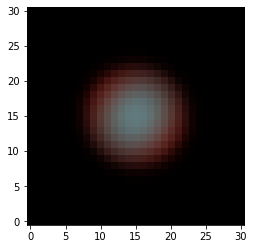

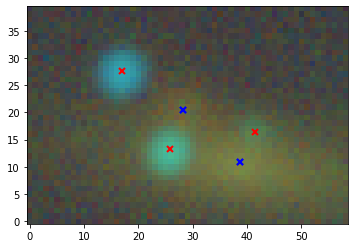

In [48]:
# Use this to point to the location of the data on your system
# Load the sample images
data = np.load("../../data/psf_unmatched_sim.npz")
images = data["images"]
filters = data["filters"]
psfs = data["psfs"]
catalog = data["catalog"]
# Estimate of the background noise level
weights = np.ones_like(images) / 2**2

# display psfs
pnorm = AsinhMapping(minimum=psfs.min(), stretch=psfs.max()/20, Q=20)
prgb = scarlet.display.img_to_rgb(psfs, norm=pnorm)
plt.imshow(prgb)
plt.show()

# Use Asinh scaling for the images
norm = AsinhMapping(minimum=images.min(), stretch=10, Q=20)
# Map i,r,g -> RGB
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    if src["is_star"]:
        plt.plot(src["x"], src["y"], "rx", mew=2)
    else:
        plt.plot(src["x"], src["y"], "bx", mew=2)
plt.show()

## Fit the PSFs

To avoid artifacts that arise when performing a full deconvolution on exteneded objects, we choose a small "reference" PSF and calculate the difference kernel to match the PSF in each band to that reference. See [Matching PSF's](psf_matching.ipynb) for a more detailed explanation of PSF matching.

In [49]:
# Get the target PSF to partially deconvolve the image psfs
from functools import partial
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=0.8))

## Initialize the Frame and the Observations

In [50]:
model_frame = scarlet.Frame(images.shape, psf=model_psf, channels=filters)
observation = scarlet.Observation(images, 
                                  psf=scarlet.PSF(psfs), 
                                  weights=weights,
                                  channels=filters)
observation = observation.match(model_frame)

## Initialize the sources

Here is where we define the sources. In this case we know which ones are stars and which are galaxies, which may or may not be realistic depending on the depth and locations of the images taken. For example, at depths shallower than GAIA it should be possible to flag most of the stars in regions outside the galactic bulge, while in more crowded fields or long exposures a different method might be needed (such as color priors on stars vs galaxies) to determine which sources to model as point sources and which ones to model as extended objects.

In [51]:
# Initalize the sources
sources = []
for idx in np.unique(catalog["index"]):
    src = catalog[catalog["index"]==idx][0]
    if src["is_star"]:
        new_source = scarlet.PointSource(
            model_frame, 
            (src["y"], src["x"]),
            observation
        )
    else:
        new_source = scarlet.ExtendedSource(
            model_frame,
           (src["y"], src["x"]),
            observation
        )
    sources.append(new_source)

Notice that we fix the morphology (`fix_morph=True`) and normalize the $S$ matrix for point sources. This allows us to only set the central pixel and never update it. This is described in more detail in the [User Guide](../user_docs.ipynb#Normalization). You'll also notice that we passed the point sources the full PSF in each band, whereas for the extended sources we pass the difference kernel. This is because a point source is a fully deconvolved representation of the object while extended sources are partially deconvolved. It also means that we have to be careful if we have a scene like this that is a mixture of extended sources and point sources. In order to have a consistent sparse (partially deconvolved) representation of the scene we need to convolve the point sources with the _target PSF_, not the full PSF that matches the image, once deblending has been completed to generate our model.

Also notice that we used the same $S$ normalization for both the point sources and extended sources, which allows us to have a consistent definition of $A$ and $S$ for all sources, regardless of their type.

## Create the blend and initialize the sources

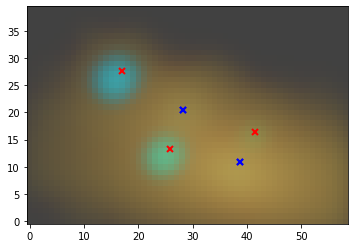

In [52]:
# Initialize the Blend object, which later fits the model
blend = scarlet.Blend(sources, observation)

# Display the initial model
model = blend.get_model()
model_ = observation.render(model)
img_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    if src["is_star"]:
        plt.plot(src["x"], src["y"], "rx", mew=2)
    else:
        plt.plot(src["x"], src["y"], "bx", mew=2)
plt.show()

Our three stars (the red x's) are initialized to match their peak value with the peak of the image while the extended sources are initialized in the usual way.

## Fit the model and display the results

Solution did not converge


CPU times: user 6.26 s, sys: 148 ms, total: 6.41 s
Wall time: 1.61 s
scarlet ran for 55 iterations to MSE = 867777.2860339199


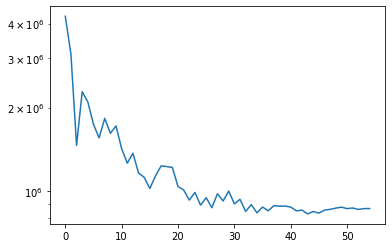

In [53]:
%time blend.fit(200)
print("scarlet ran for {0} iterations to MSE = {1}".format(len(blend.loss), blend.loss[-1]))
plt.semilogy(blend.loss)

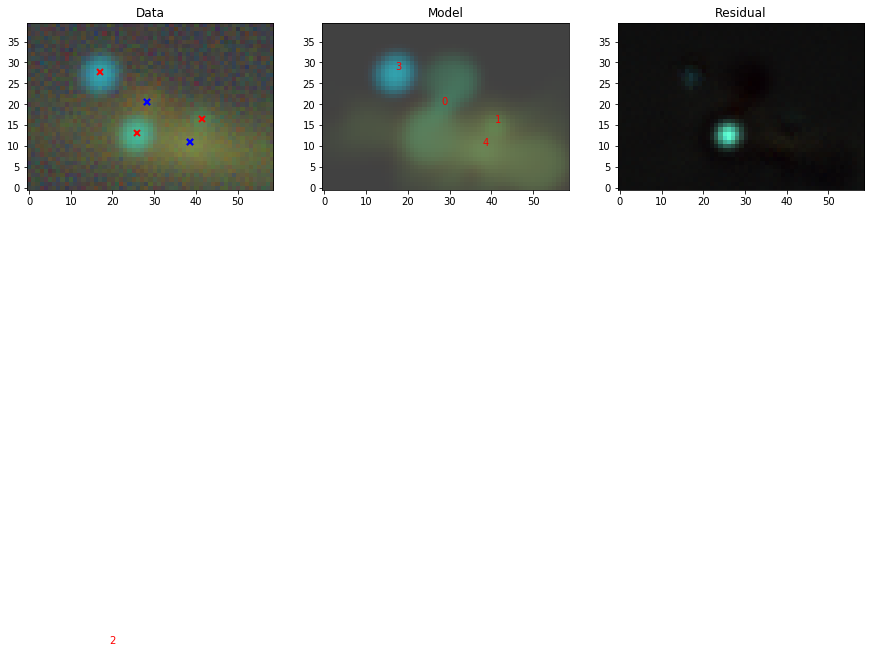

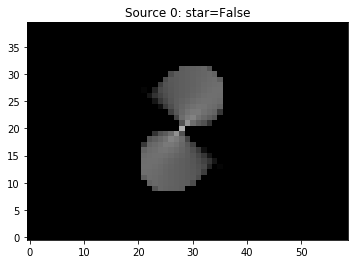

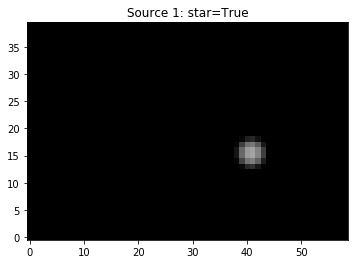

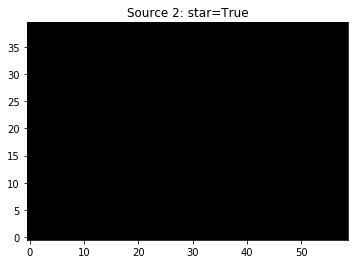

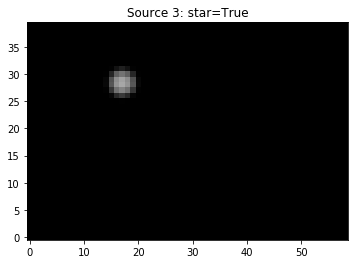

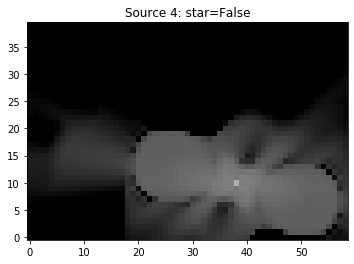

Total residual 152516.556146132


In [54]:
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]

# Display the data
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
for src in catalog:
    if src["is_star"]:
        ax[0].plot(src["x"], src["y"], "rx", mew=2)
    else:
        ax[0].plot(src["x"], src["y"], "bx", mew=2)

# Display the model
model = blend.get_model()
model_ = observation.render(model)
img_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
ax[1].imshow(img_rgb)
ax[1].set_title("Model")
for k, src in enumerate(blend.sources):
    y,x = src.center
    ax[1].text(x, y, str(k), color="r")

# Display the residual
residual = images-model_
img_rgb = scarlet.display.img_to_rgb(residual)
ax[2].imshow(img_rgb)
ax[2].set_title("Residual")

# Show the plots
plt.show()

# Show the morphologies
for k, src in enumerate(blend.sources):
    asinh = AsinhMapping(minimum=0, stretch=1/20, Q=10)
    morph = scarlet.display.img_to_rgb(src.morph, norm=asinh)
    plt.title("Source {0}: star={1}".format(k, catalog[catalog["index"]==k][0]["is_star"]))
    plt.imshow(morph)
    plt.show()

print("Total residual {0}".format(np.sum(np.abs(residual))))

The dipoles we see at the center of the stellar sources is because the catalog offset the centers of all the sources by a random amount and by fixing the morphology we also cannot adjust the position, which also caused the code to require a greater number of iterations for convergence. A future version of *scarlet* will hopefully address this unfortunate side effect of fitting PSF stars.